In [25]:
import scanpy as sc
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import importlib


import stereo_seq.constants.paths as scp
import stereo_seq.constants.celltype_maps as scc
import stereo_seq.utils.plotting as pl
import stereo_seq.utils.load as sul
import stereo_seq.utils.preprocessing as sup
import stereo_seq.constants.marker_genes as scm
import stereo_seq.constants.ordering as sco
import stereo_seq.utils.exploration as sue

BASE_DIR = scp.BASE_DIR
DATA_DIR = scp.DATA_DIR
FIGURE_DIR = scp.FIGURE_DIR
GROUP_MAPPING =  scc.SUBClASS_TO_CLASS_MAPPING
PLT_CONTEXT=pl.PLT_CONTEXT


## QC 

In [24]:
#Edit this to do different datasets
region = 'SC'
timepoint='P42'
group='DR'
subgroup='annotation'
scp.init_paths(region)

### Preprocess and annotate

In [ ]:
importlib.reload(scp)
data_dir = scp.make_path(base='data',region=region,timepoint=timepoint,group=group,subgroup='')
figure_dir = scp.make_path(base='figures',region=region,timepoint=timepoint,group=group,subgroup=subgroup)
samples=scp.SAMPLES[region][timepoint][group]

In [ ]:
adata = sul.merge_dfs(samples,f="filtered_feature_bc_matrix",out_f=os.path.join(data_dir,"merged_raw.h5ad"),format="custom")
sup.pipeline(adata,batch=False,min_genes=100,output_f=os.path.join(data_dir,"merged_filt.h5ad"),figure_dir=figure_dir,inplace=True)

In [ ]:
import pandas as pd
importlib.reload(sup)
importlib.reload(scm)
importlib.reload(scc)
importlib.reload(sup)
#adata = sc.read_h5ad(os.path.join(data_dir,"merged_filt.h5ad"))
df = sup.annotate_adata(adata,scm.MARKER_GENES, class_col='subclass', override=scc.UNCERTAIN_MAPPING[region][timepoint][group]['clust_class_override'], plot=False,save=False)

In [ ]:
import stereo_seq.utils.exploration as sue
class_subtypes = sue.create_subtypes(adata,groupby='subclass',subgroups=sco.CLASS_ORDER,key_added='subtypes',output_f="")
importlib.reload(sco)
importlib.reload(sue)
sue.summary_stats(
    adata,
    subtype_col='subtypes',color_col='subclass',
    var_names=None,
    categories_order=None,
    figure_dir=figure_dir,
    output_pre="init_"
)
adata.obs['class'] = pd.Categorical(adata.obs['subclass'].map(scc.SUBClASS_TO_CLASS_MAPPING))
assert not any(pd.isna(adata.obs['class']))
adata.write_h5ad(os.path.join(data_dir,"merged_filt.h5ad"))

In [ ]:
importlib.reload(sup)
sup.split_and_save(
    adata,
    col='class',
    data_dir=data_dir,
    detect_doublets=True,
    override_info=None,
    output_pre=""
)

### Reannotate Non-neuronal

In [ ]:
adata=sc.read_h5ad(os.path.join(data_dir,"Non-neuronal.h5ad"))
importlib.reload(sup)
importlib.reload(scc)
for x in ['subclass','subtypes']:
    if x in adata.obs.columns:
        del adata.obs[x]
df = sup.annotate_adata(adata,scm.MARKER_GENES, class_col='subclass', override=scc.UNCERTAIN_MAPPING[region][timepoint][group]['Non-neuronal_override'],cluster_col='subleiden', plot=False,output_f=os.path.join(data_dir,"Non-neuronal.h5ad"))

### Merge NR subadata into main adata

In [ ]:
adata_lst =[os.path.join(data_dir,f"{cl}.h5ad") for cl in sorted(list(set(scc.SUBClASS_TO_CLASS_MAPPING.values())))]
importlib.reload(sup)
adata_merged=sc.read_h5ad(os.path.join(data_dir,"merged_filt.h5ad"))
sup.postprocess_and_merge(
    adata_merged=adata_merged,
    adata_lst=adata_lst,
    subclass_col='subclass',
    subtype_col='subtypes',
    rep_col='sample',
    cluster_key='subleiden',
    detect_doublets=True,
    subclass_order=sco.CLASS_ORDER,
    override_info={'col':'subclass','name':'Doublet'},
    output_f=os.path.join(data_dir,"merged_final.h5ad")
)

In [ ]:
adata = sc.read_h5ad(os.path.join(data_dir,"merged_final.h5ad"))
importlib.reload(scm)
importlib.reload(sue)
importlib.reload(pl)
sue.summary_stats(
    adata,
    subtype_col='subtypes',color_col='subclass',
    var_names=None,
    categories_order=None,
    figure_dir=figure_dir,
    output_pre="fin_"
)

In [ ]:

sue.summary_stats(
    adata,
    subtype_col='subtypes',color_col='subclass',
    var_names=None,
    categories_order=None,
    figure_dir=figure_dir,
    output_pre="init_"
)

### Classification

In [ ]:
import stereo_seq.models.model_info as smi
import stereo_seq.utils.classifier as suc

importlib.reload(smi),importlib.reload(suc)

def run_classification_pipeline(region,timepoint,model_name,test_data_dir,test_col,key_added,preprocess_train=True,preprocess_test=False,train_model=False,run_full=False,evaluate_test=True,resave=True):
    info = smi.get_model_info(region,timepoint,model_name)
    dataset_info = info['dataset']
    model_info = info['model']
    test_group=smi.MODEL_GROUP_MAP[model_name]#Consider replacing test_gorup and test_data_dir with test_f directly


    adata_train = dataset_info['loader'](dataset_info['path'])
    test_f=os.path.join(os.path.join(test_data_dir,f"{test_group}.h5ad"))
    adata_test = sc.read_h5ad(test_f)#Already preprocessed
    suc.train_and_test(
        adata_train,
        adata_test,
        **model_info,
        test_output_f="test_set.png",
        test_col=test_col,
        key_added=key_added,
        genes=None,
        cutoff=0.5,
        preprocess_train=preprocess_train,
        preprocess_test=preprocess_test,
        train_model=train_model,
        run_full=run_full,
        evaluate_test=evaluate_test,
    )

    if resave:
        adata_test.write_h5ad(test_f)
    return adata_test

In [ ]:
region,timepoint,model_name = 'SC','P42','excitatory_Xie_SC'
test_data_dir,test_col,key_added = scp.make_path(base='data',region=region,timepoint=timepoint,group="NR",subgroup=''),'subleiden','Xie_type'

run_classification_pipeline(
    region,timepoint,model_name,test_data_dir,test_col,key_added,
    preprocess_train=True,preprocess_test=False,train_model=False,run_full=False,evaluate_test=True
)

In [ ]:
importlib.reload(smi)
for mname in ['excitatory_NR','non-neuronal_NR','inhibitory_NR']:
    region,timepoint,model_name = 'SC','P42',mname
    test_data_dir,test_col,key_added = scp.make_path(base='data',region=region,timepoint=timepoint,group="DR",subgroup=''),'subleiden','NR_subleiden'

    adata_test = run_classification_pipeline(
        region,timepoint,model_name,test_data_dir,test_col,key_added,
        preprocess_train=False,preprocess_test=False,train_model=False,run_full=False,evaluate_test=True
    )

### NRDR 

In [13]:
region = 'SC'
timepoint='P42'
group='NRDR'
subgroup='annotation'
importlib.reload(scp)
scp.init_paths(region)


data_dir = scp.make_path(base='data',region=region,timepoint=timepoint,group=group,subgroup='')
data_dir_NR = scp.make_path(base='data',region=region,timepoint=timepoint,group="NR",subgroup='')
data_dir_DR = scp.make_path(base='data',region=region,timepoint=timepoint,group="DR",subgroup='')
figure_dir = scp.make_path(base='figures',region=region,timepoint=timepoint,group=group,subgroup=subgroup)

In [16]:
importlib.reload(sup)
def _post_merge(adata):
    adata.X=adata.raw.X.copy()
    del adata.layers['log1p']
    adata.obs['rearing_condition'] = [x[0:2] for x in adata.obs['sample']]

for group in scc.CLASSES:
    data_str = f"{group}.h5ad"
    sup.merge_and_reprocess(
        adata_lst=[
            os.path.join(data_dir_NR,data_str),
            os.path.join(data_dir_DR,data_str)
        ],
        joint_cluster_key_added='NRDR_leiden',
        figure_dir=figure_dir,
        output_f=os.path.join(data_dir,"test.h5ad"),
        post_merge_func=_post_merge,
    )


/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
#Deprecated
"""
adata = sc.read_h5ad(os.path.join(data_dir,"Excitatory Neuron.h5ad"))
adata.obs['NR_subleiden'].fillna(adata.obs['subleiden'].cat.add_categories(['Unassigned']),inplace=True)
adata_DR2 = adata[adata.obs['rearing_condition'] == 'DR']

pl.crosstab_confusion(adata_DR2,x_col='NR_subleiden',y_col='subleiden')
sue.gen_assignment(adata_DR2,col_0='subleiden',col_1='NR_subleiden',assignment_strat='max',cutoff=0.4,unmapped_key='Unmapped')#For every type in col_0, assign to col_1 (col_1 is usually classifier)
"""

### NR vs DR genes

In [26]:
import stereo_seq.utils.exploration as sue

In [27]:
region = 'SC'
timepoint='P42'
group='NRDR'
subgroup='annotation'
importlib.reload(scp)
scp.init_paths(region)


data_dir = scp.make_path(base='data',region=region,timepoint=timepoint,group=group,subgroup='')
figure_dir = scp.make_path(base='figures',region=region,timepoint=timepoint,group=group,subgroup='classification')

Reiordering columns to try and make diagonal


/Users/kushalnimkar/Documents/PhD/Stereo-seq_Wholebrain/stereo_seq/utils/plotting.py:152: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  #xticksactual = conf_df.columns.map({v:k for k,v in train_dict.items()})


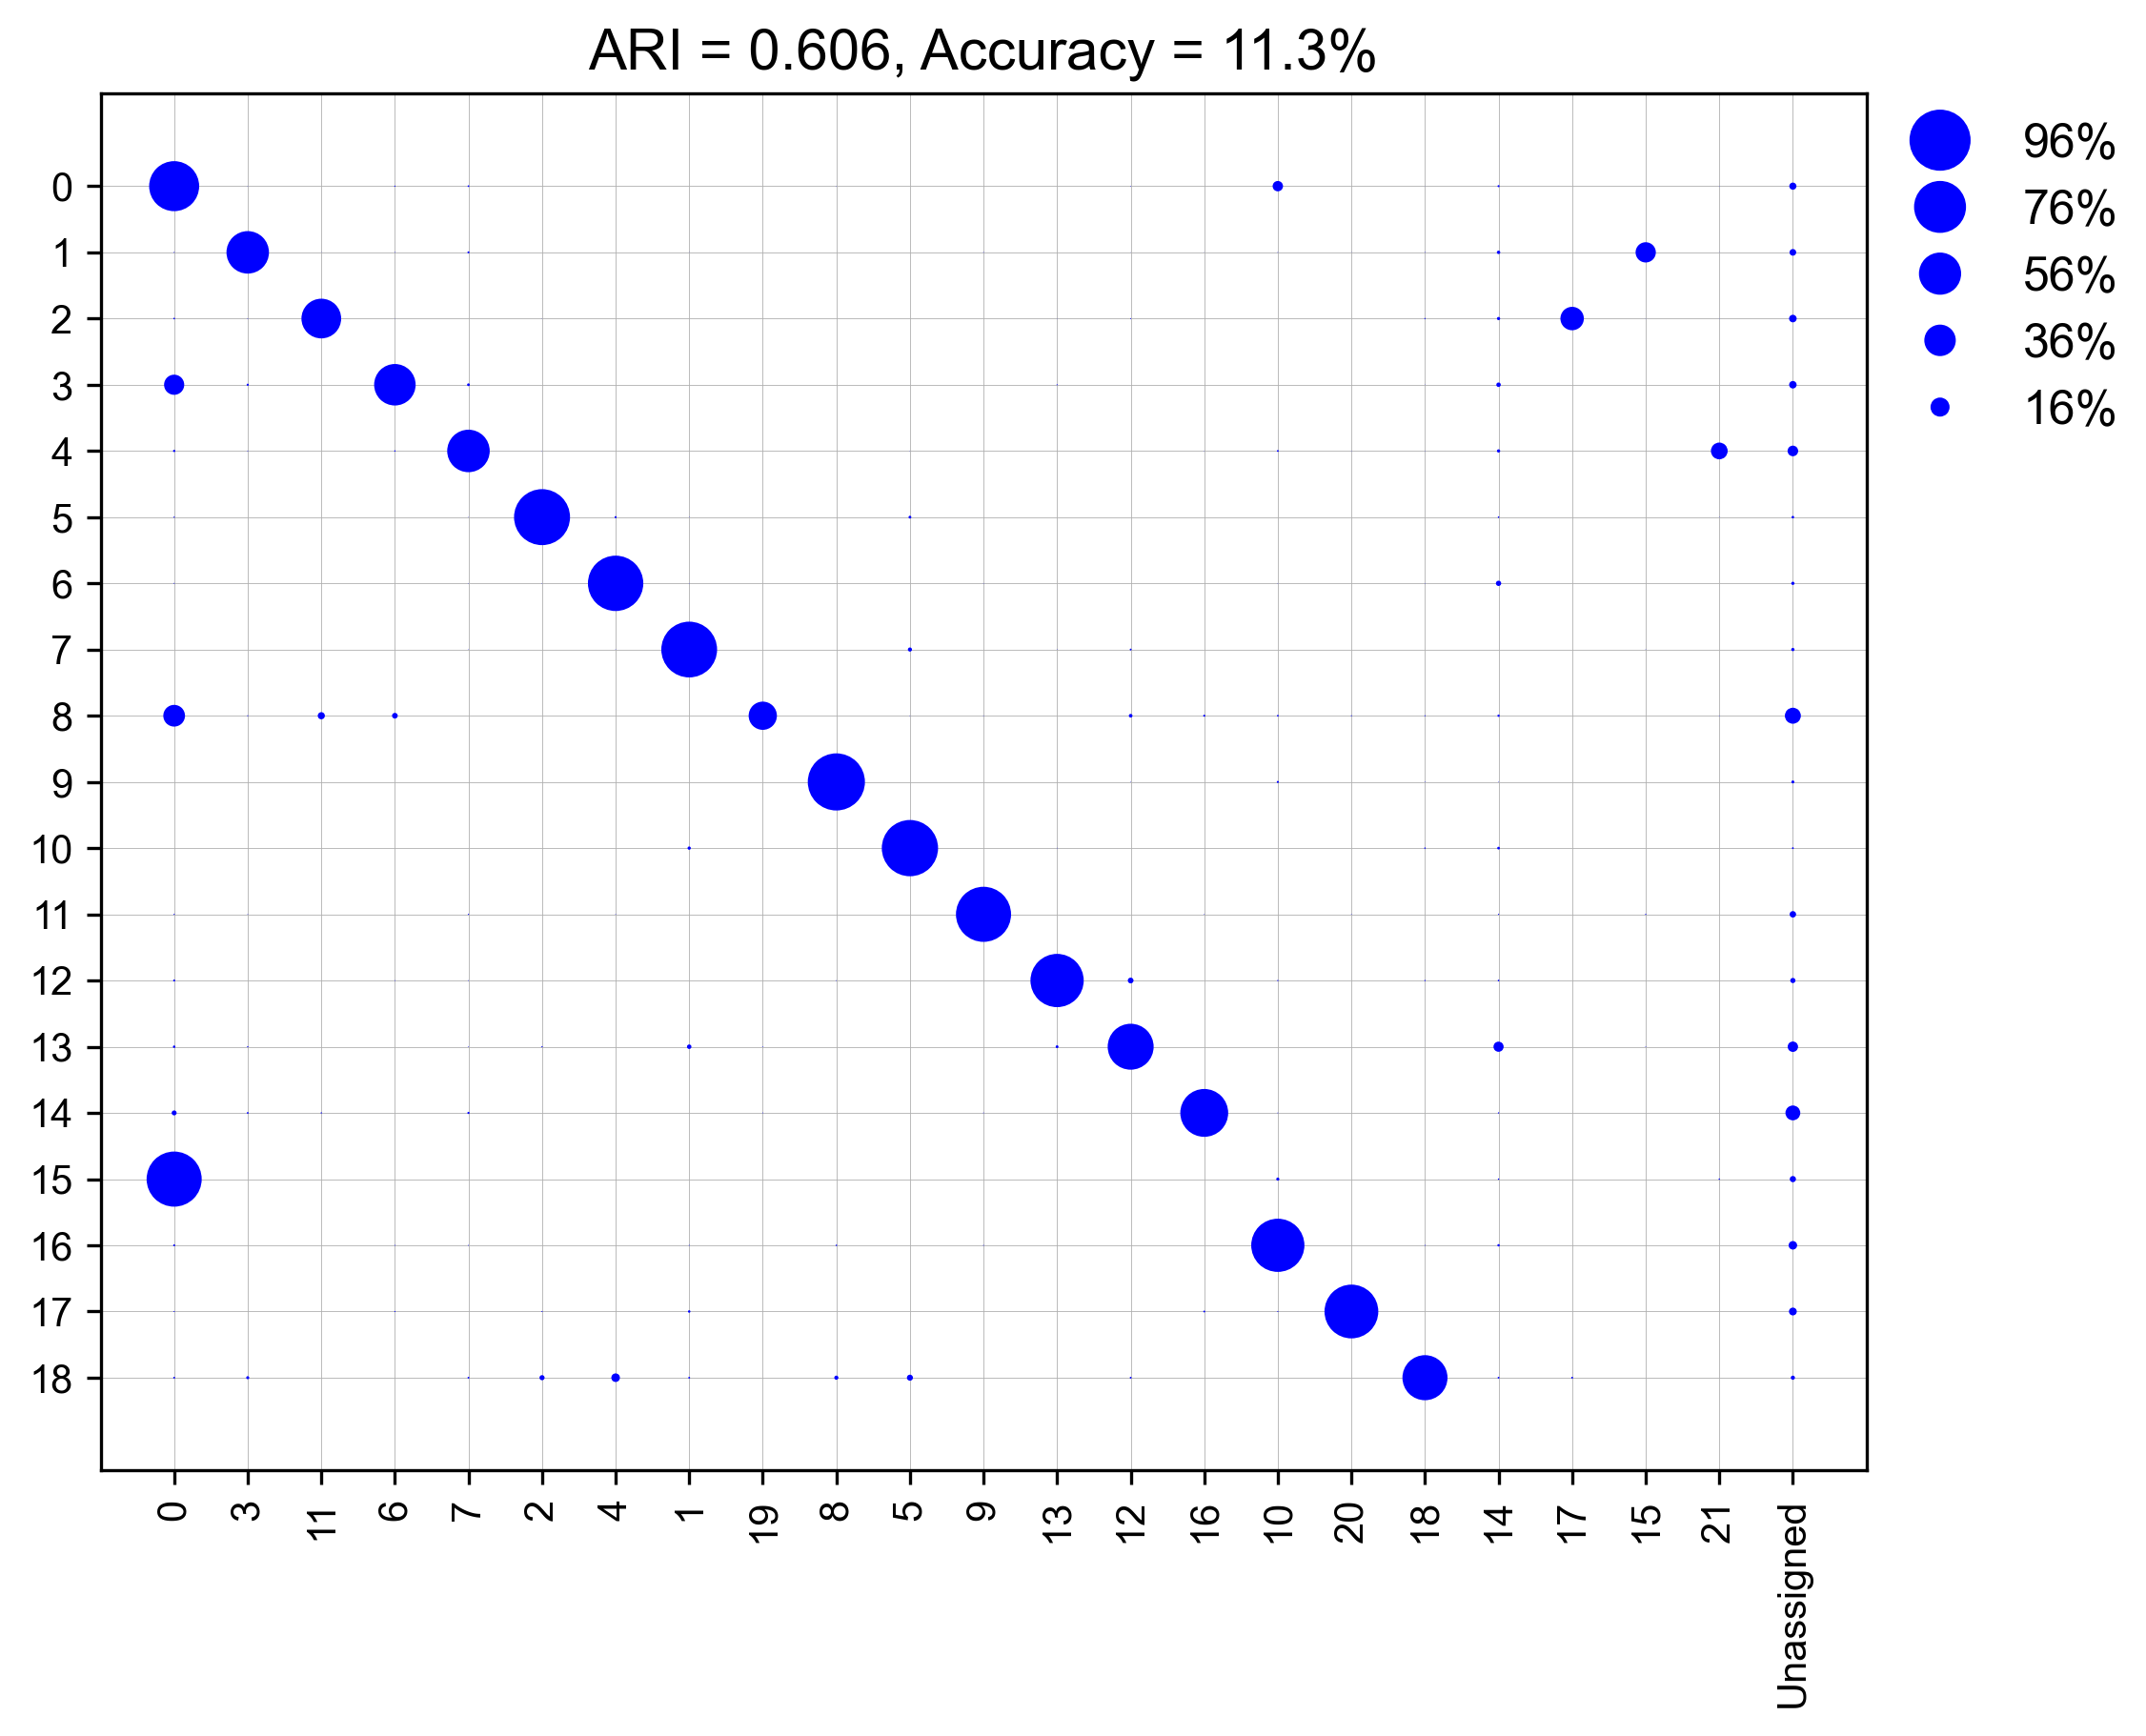

/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  

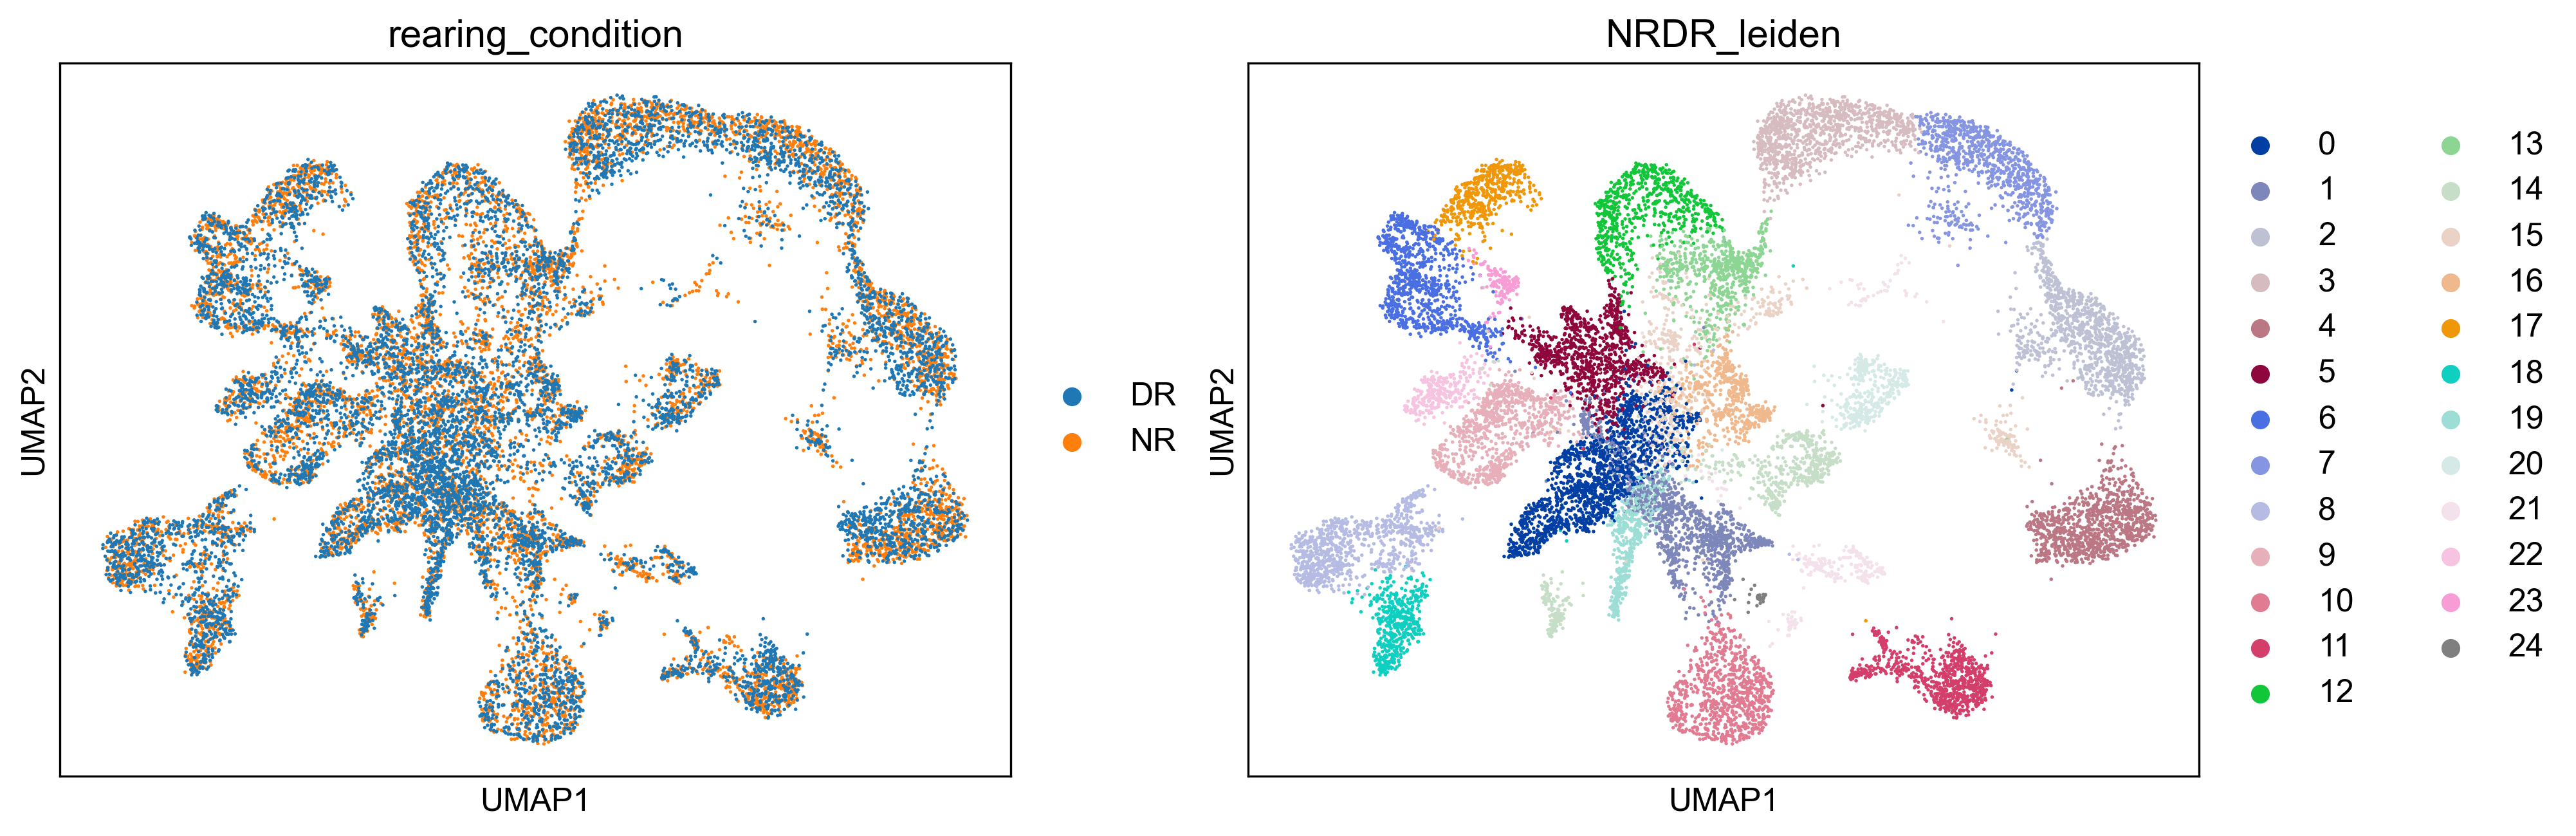

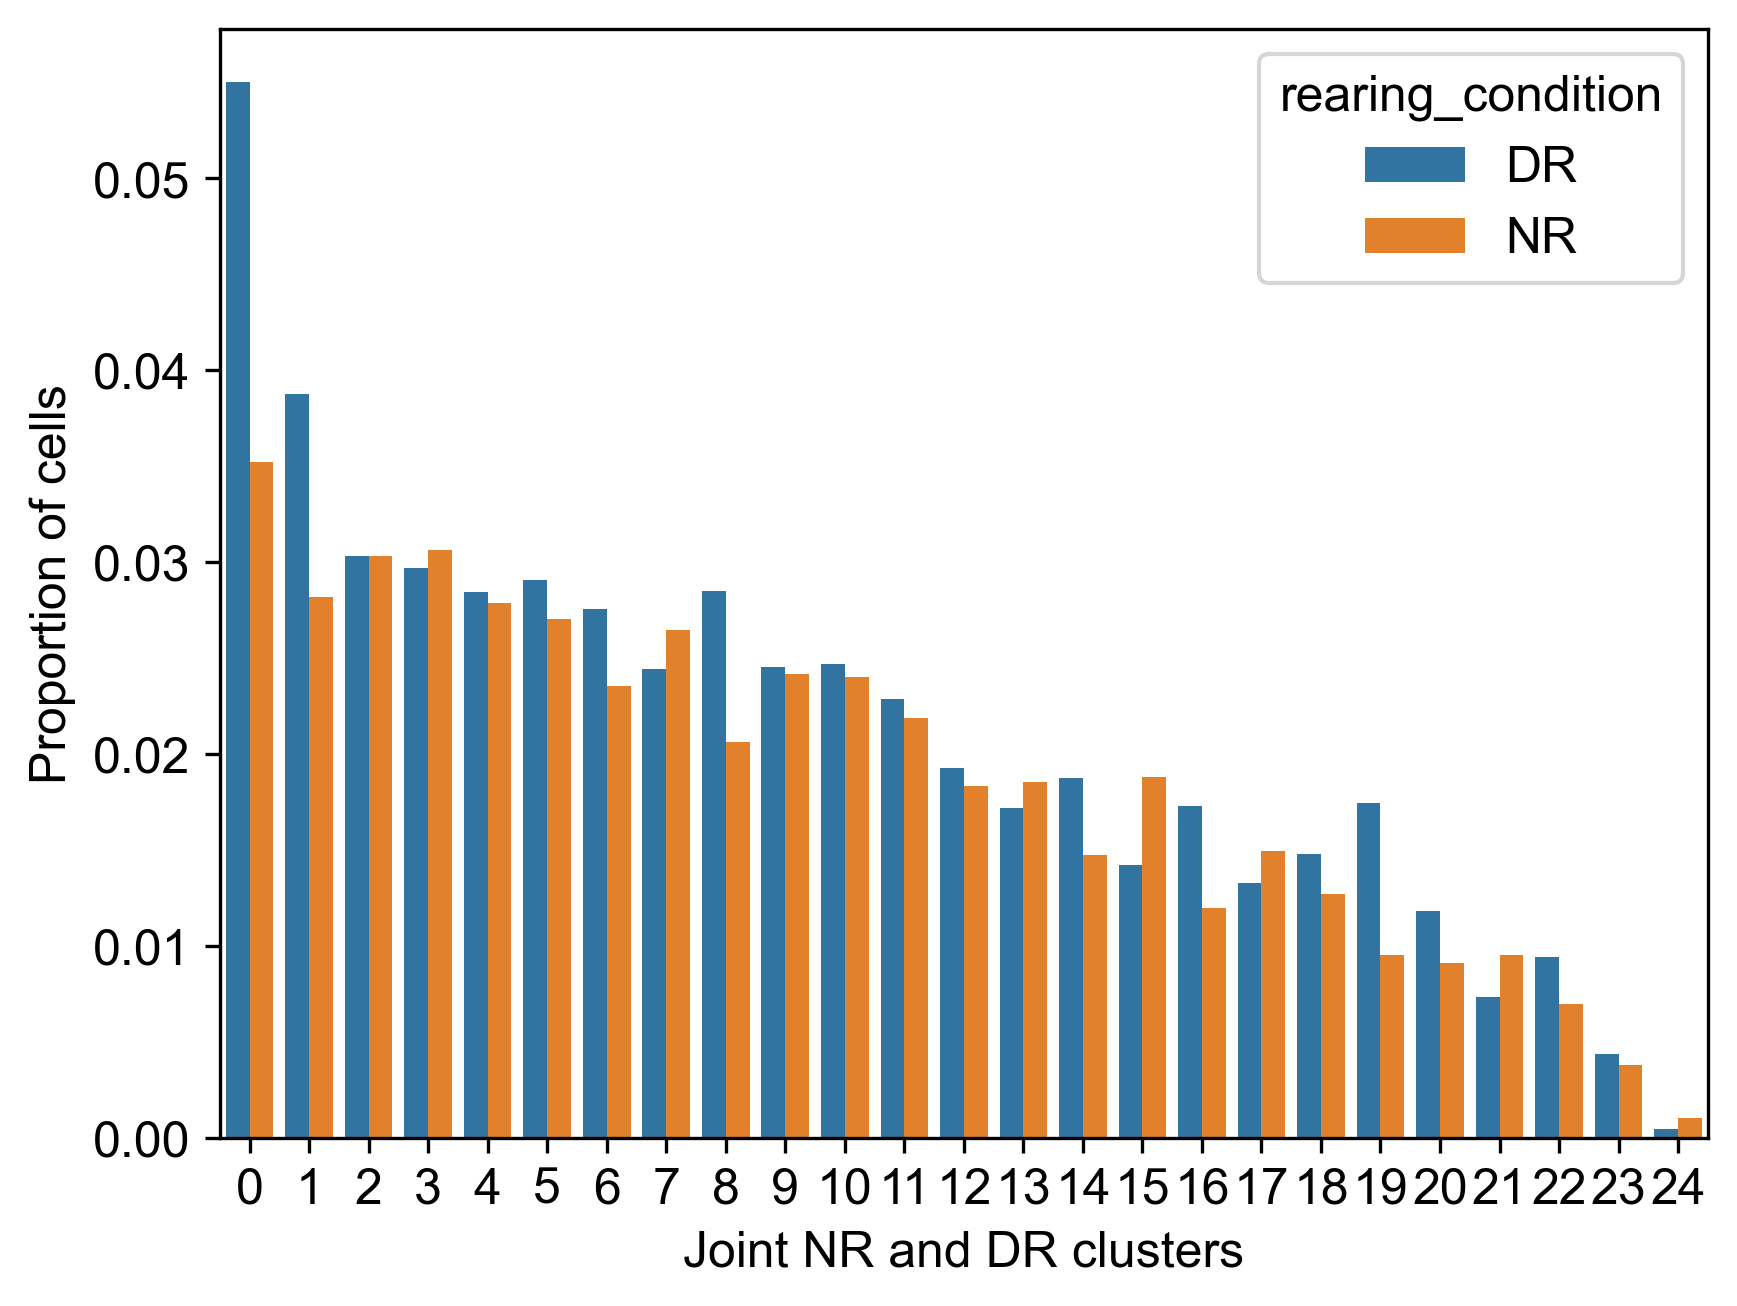

Reiordering columns to try and make diagonal


/Users/kushalnimkar/Documents/PhD/Stereo-seq_Wholebrain/stereo_seq/utils/plotting.py:152: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  #xticksactual = conf_df.columns.map({v:k for k,v in train_dict.items()})


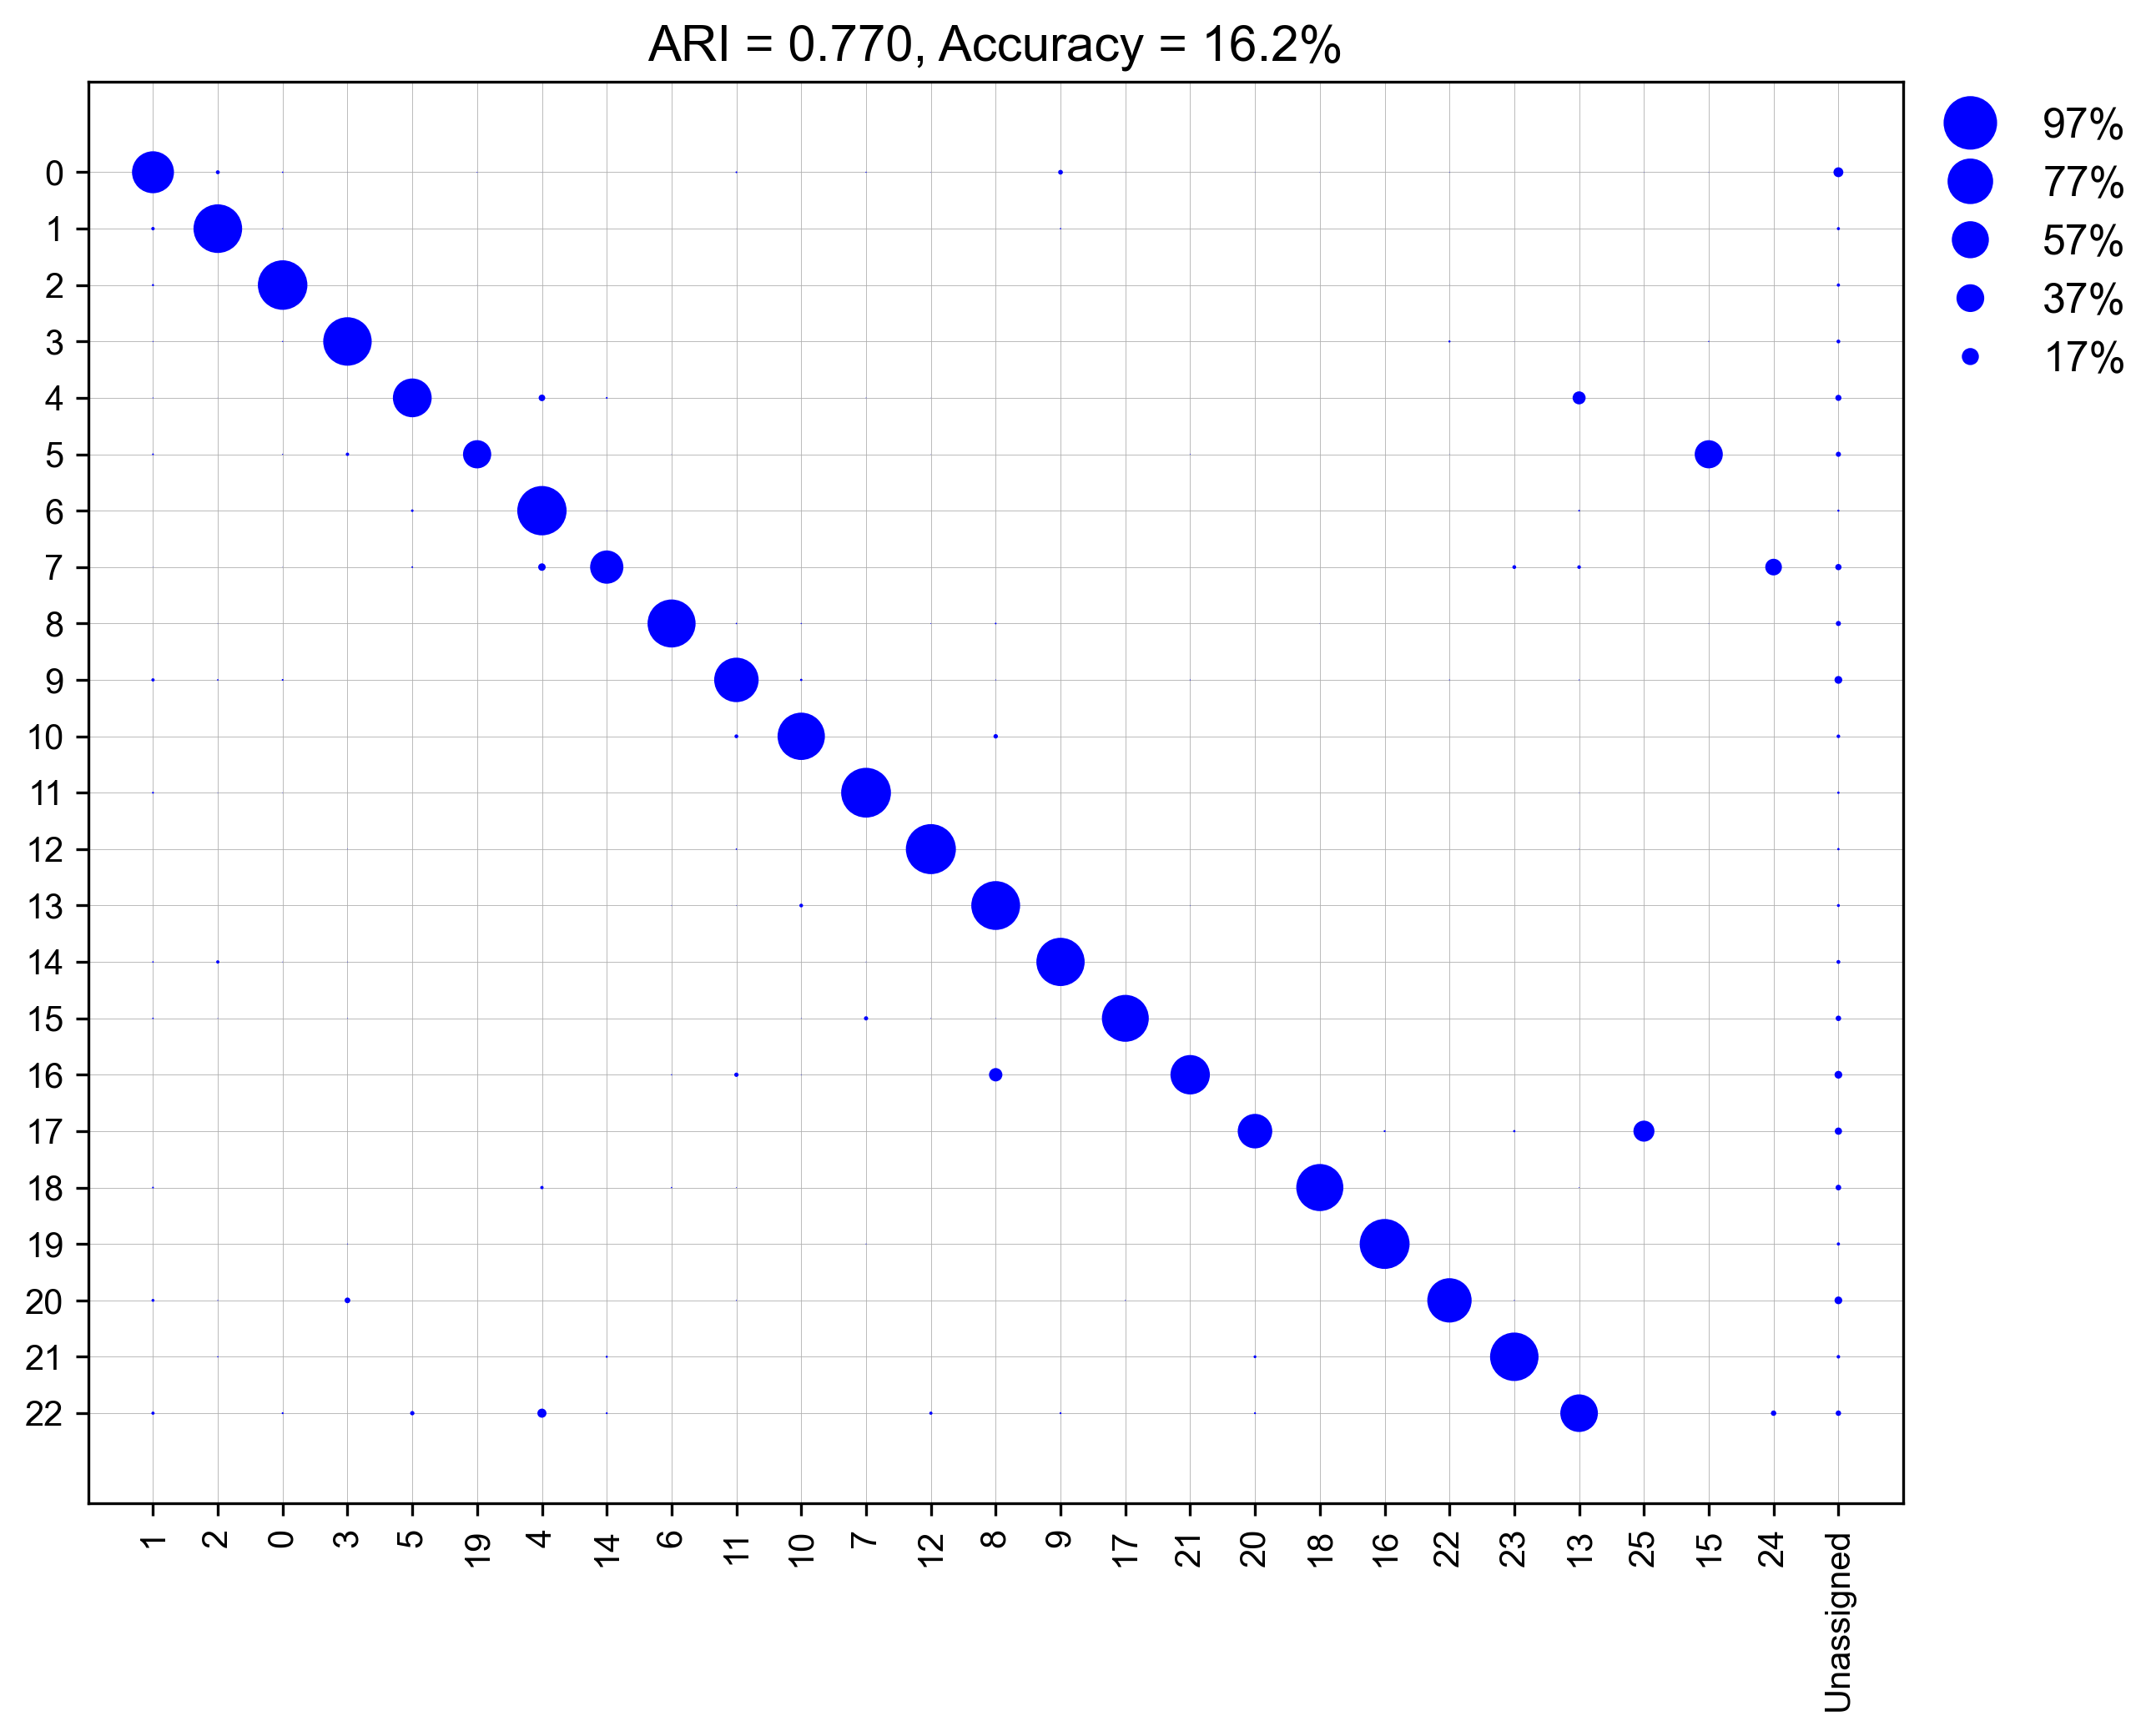

/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  

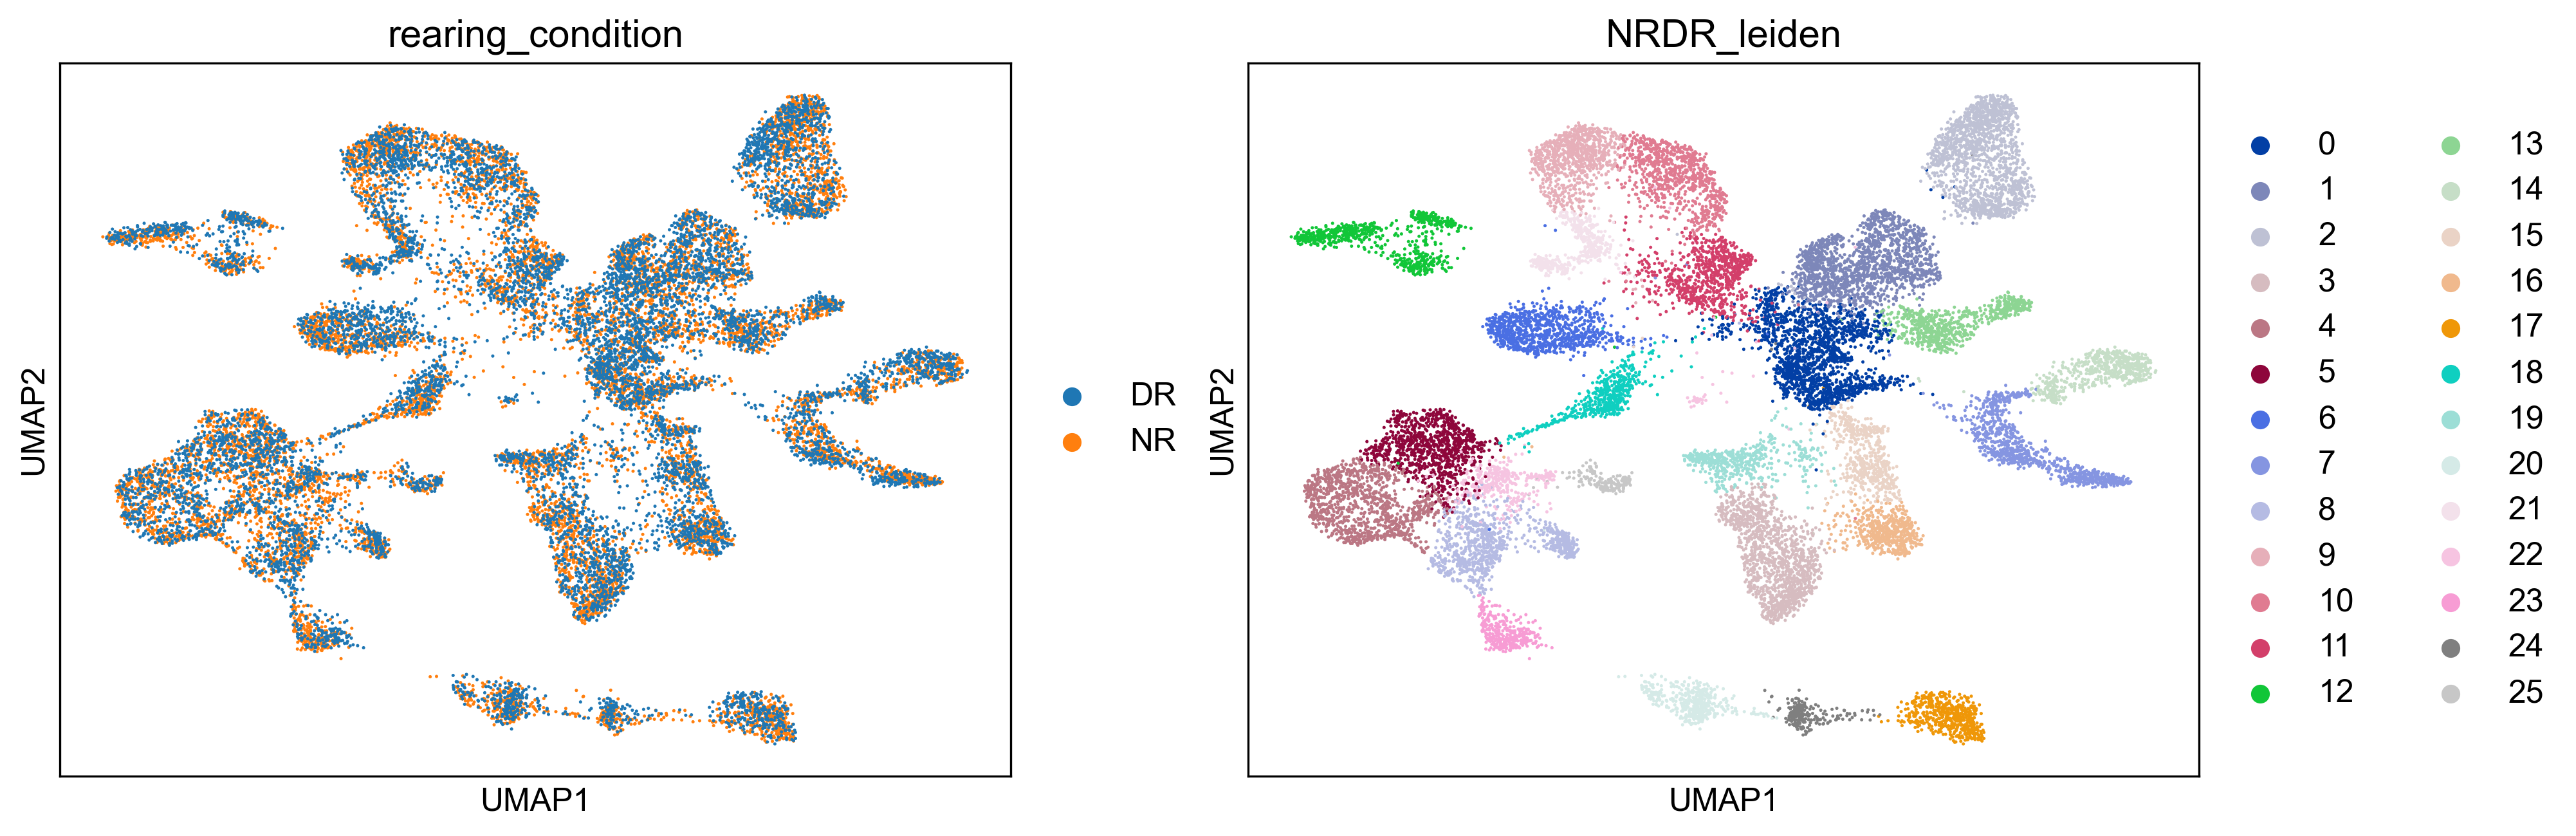

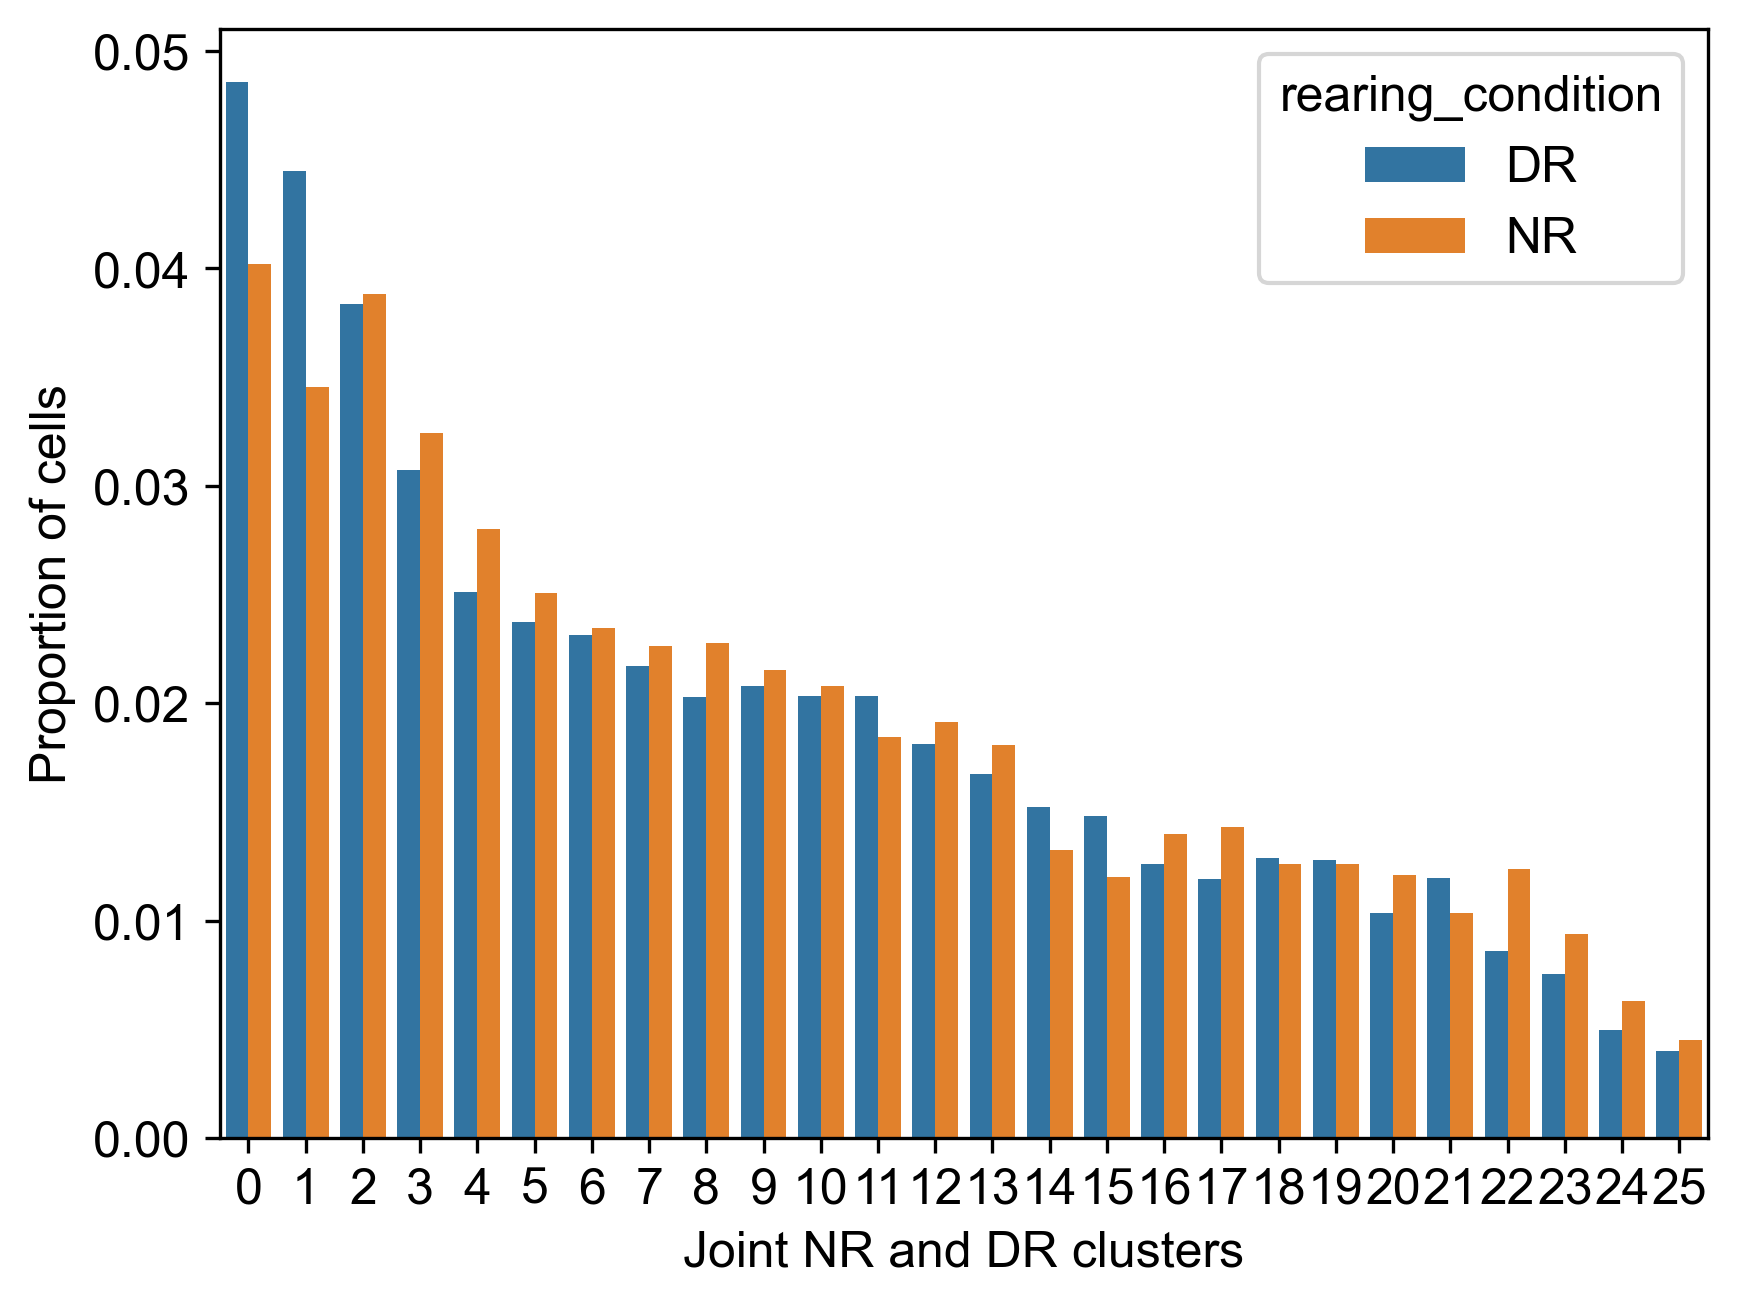

Reiordering columns to try and make diagonal


/Users/kushalnimkar/Documents/PhD/Stereo-seq_Wholebrain/stereo_seq/utils/plotting.py:152: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  #xticksactual = conf_df.columns.map({v:k for k,v in train_dict.items()})


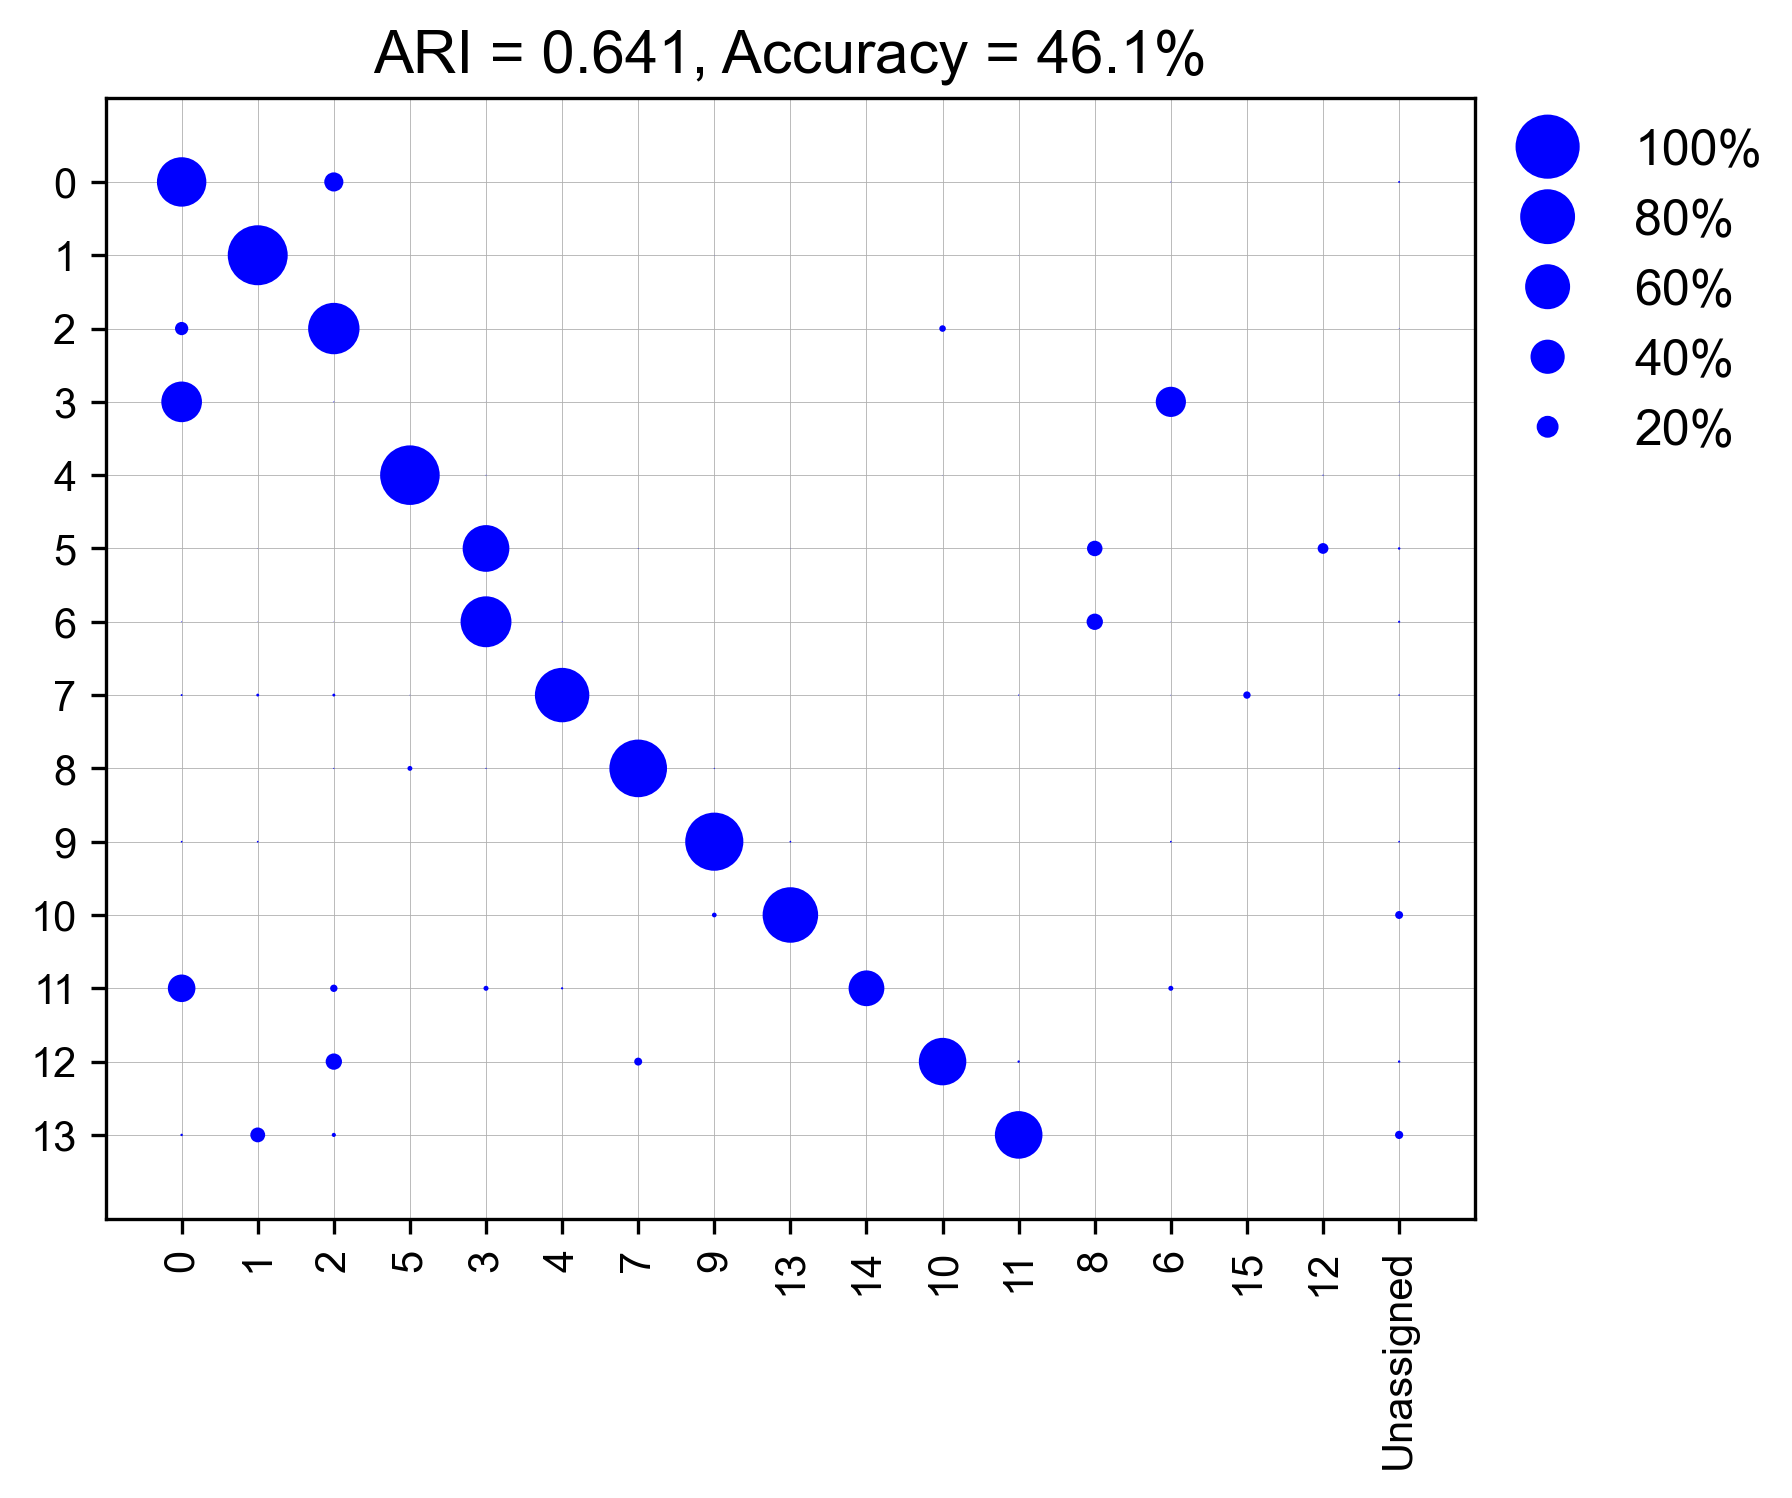

/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  

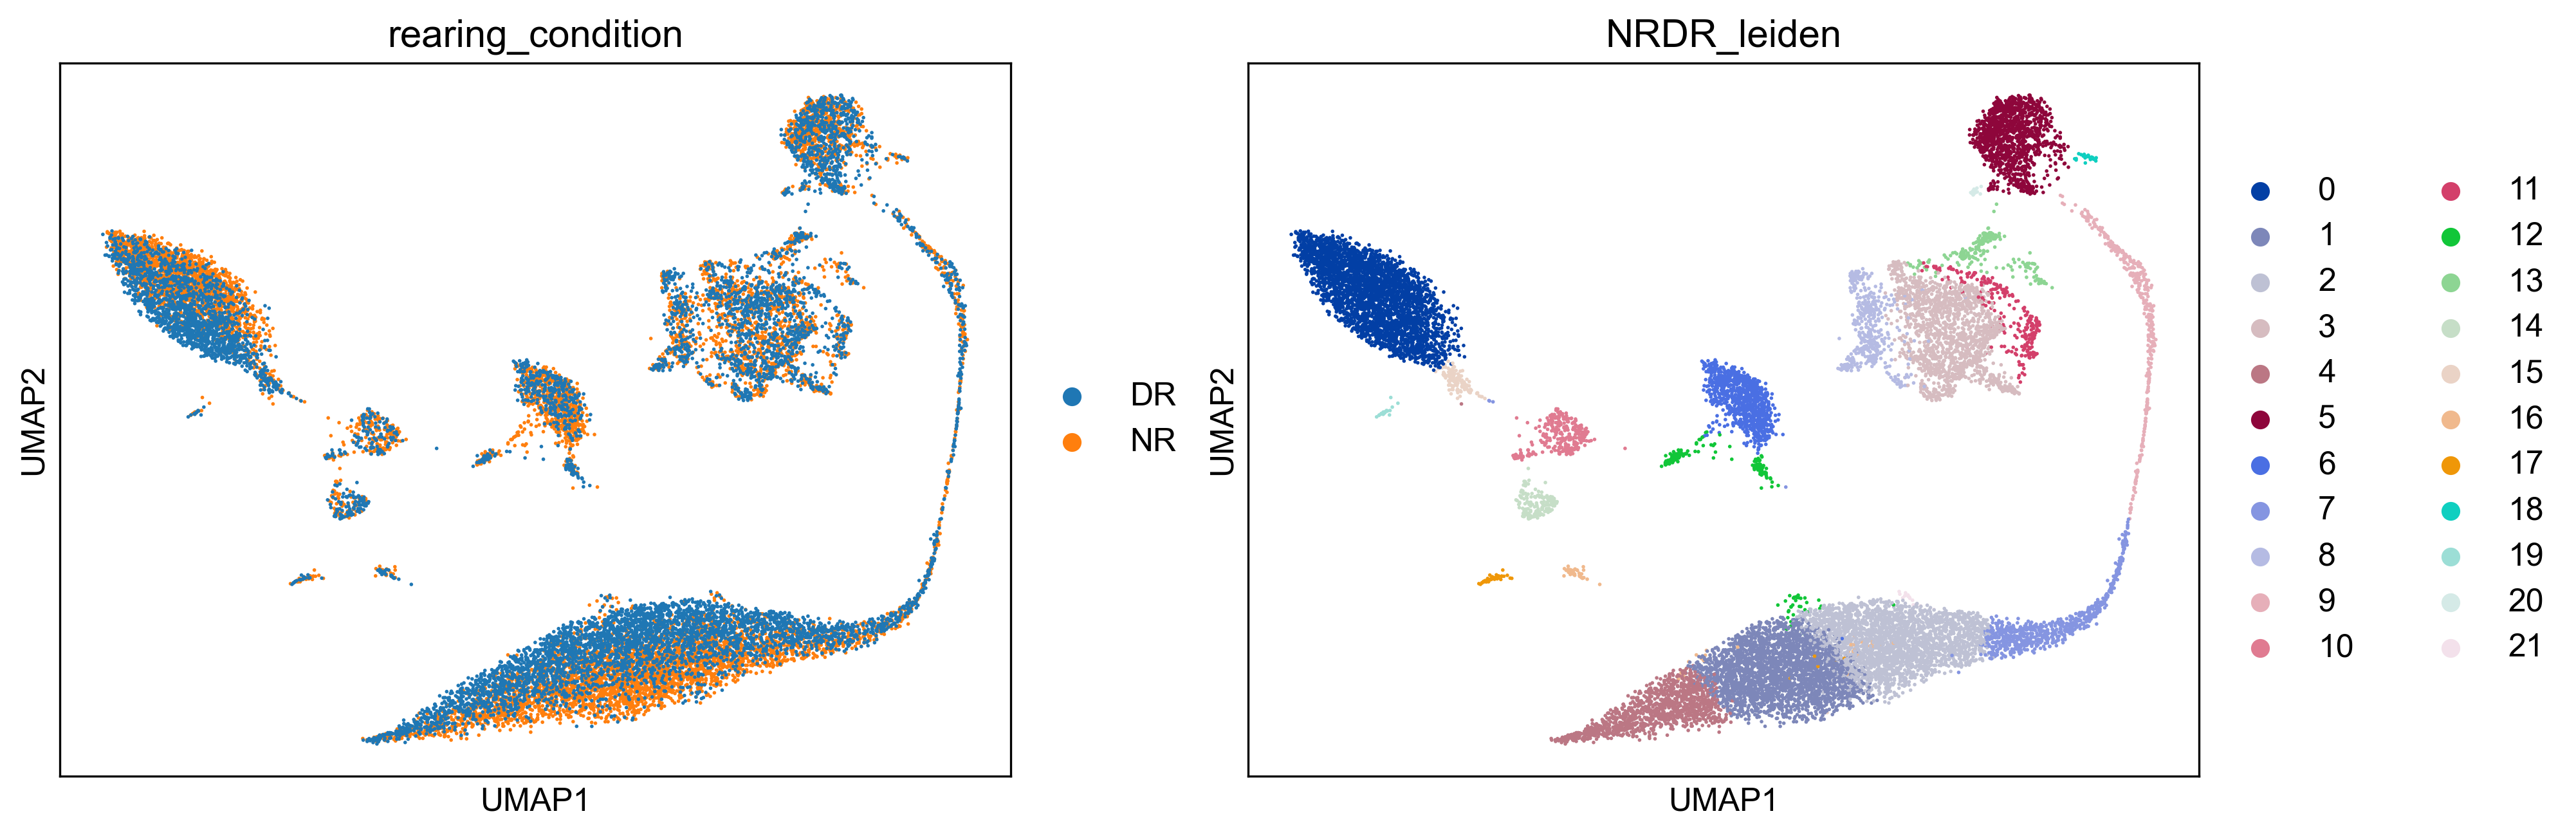

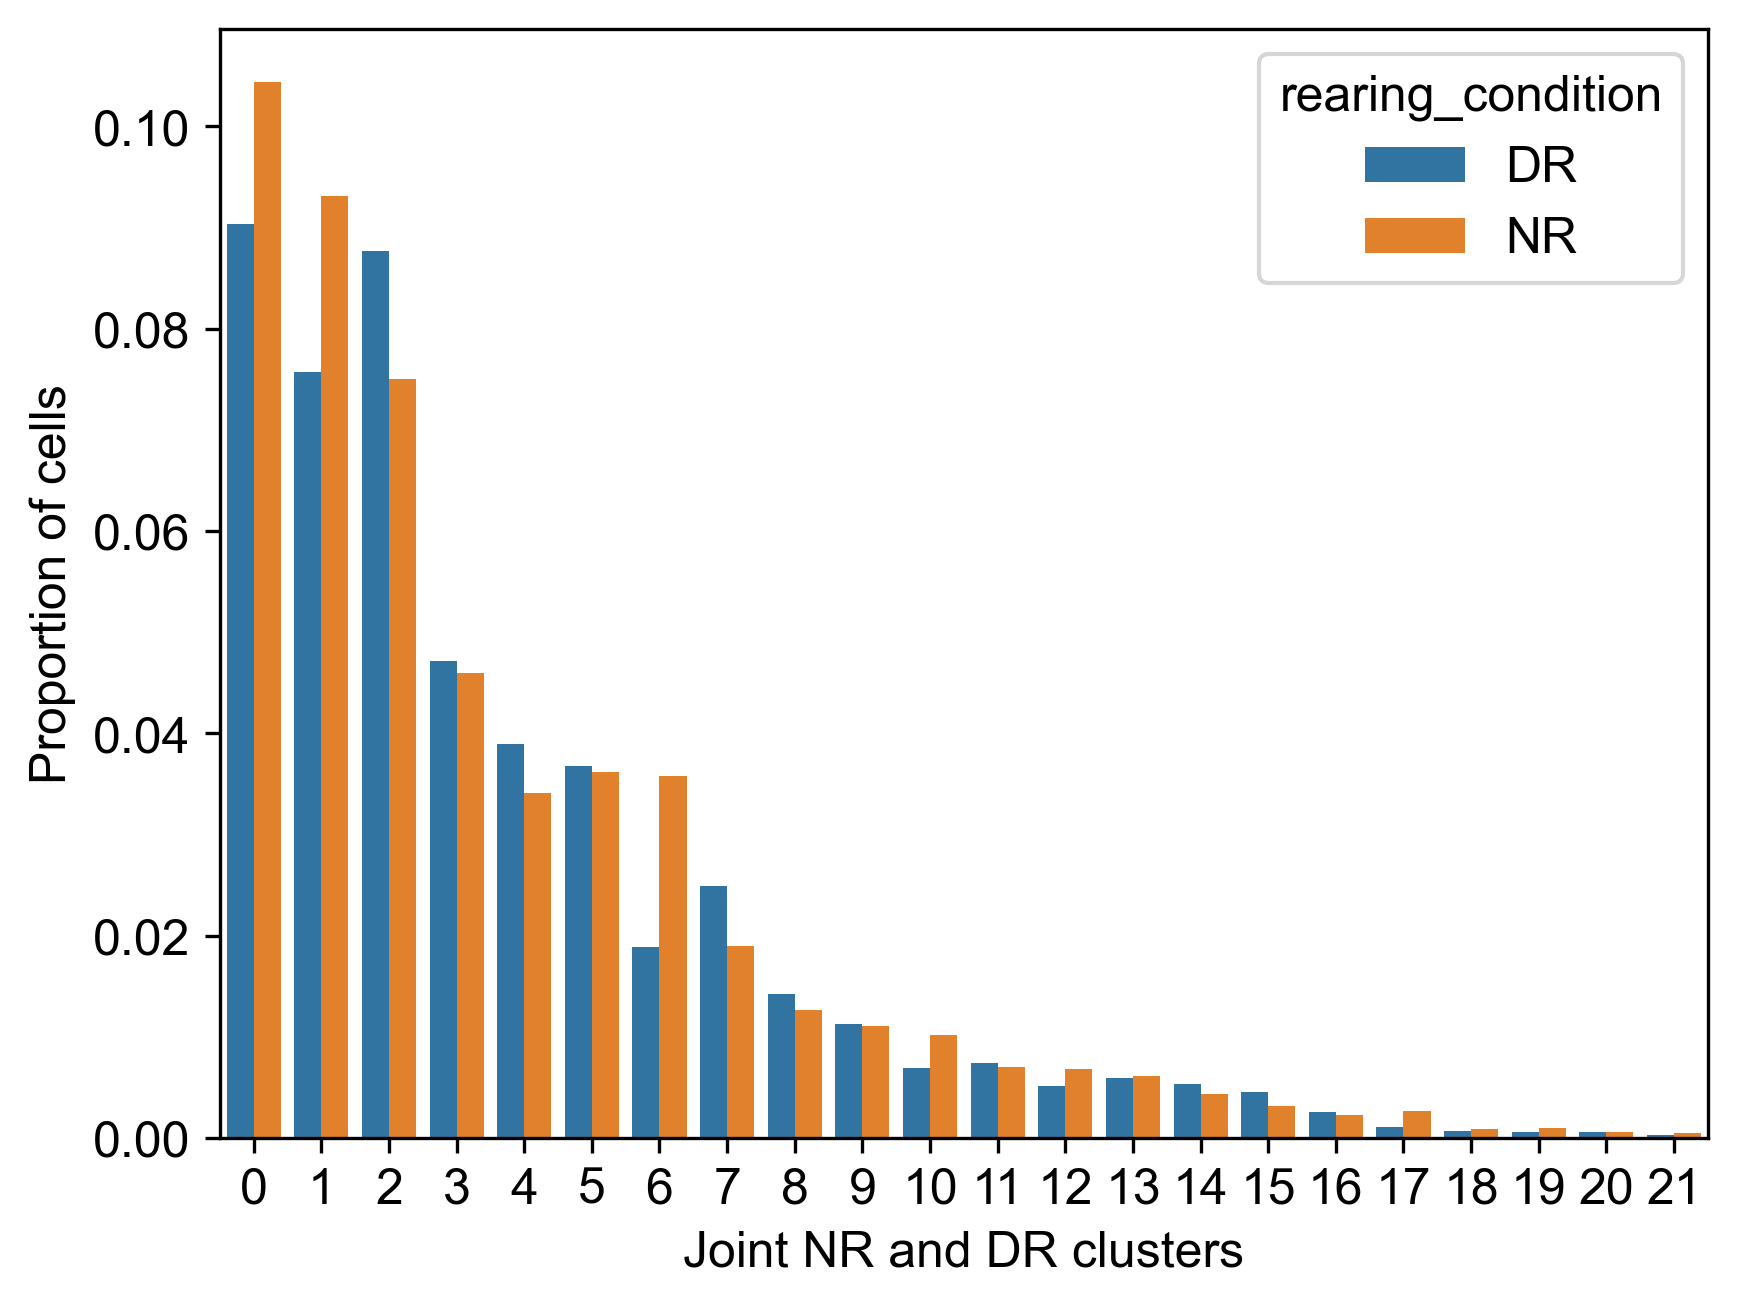

In [32]:
importlib.reload(sue)
for cl in scc.CLASSES:
    f=os.path.join(data_dir,f"{cl}.h5ad")
    adata = sc.read_h5ad(f)
    adata.obs['NR_subleiden'].fillna(adata.obs['subleiden'].cat.add_categories(['Unassigned']),inplace=True)
    adata_DR2 = adata[adata.obs['rearing_condition'] == 'DR']

    with plt.rc_context(PLT_CONTEXT):
        pl.crosstab_confusion(adata_DR2,x_col='NR_subleiden',y_col='subleiden',output_f=os.path.join(figure_dir,f"{cl}_NR_DR_mapping.png"))
        sue.gen_assignment(adata_DR2,col_0='subleiden',col_1='NR_subleiden',assignment_strat='max',cutoff=0.4,unmapped_key='Unmapped')#For every type in col_0, assign to col_1 (col_1 is usually classifier)
    
    sue.summary_integration(adata,cluster_key='NRDR_leiden',sample_key='rearing_condition',figure_dir=figure_dir,output_data_f=f)

/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', '

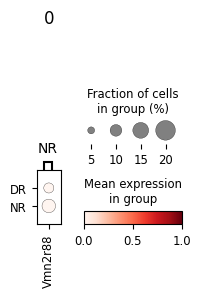

/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Skipping 1 since no diff expressed


/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Skipping 2 since no diff expressed


/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Skipping 3 since no diff expressed


/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Skipping 4 since no diff expressed


/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', '

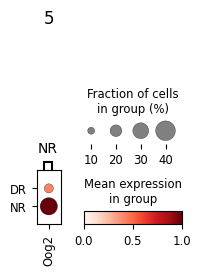

/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Skipping 6 since no diff expressed


/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', '

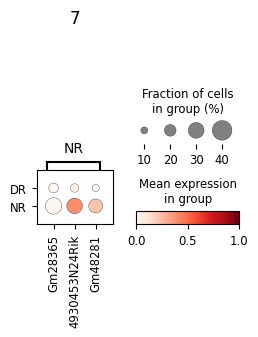

/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', '

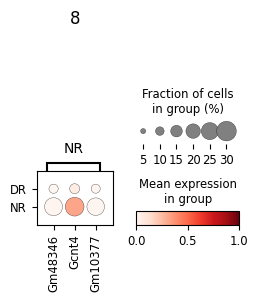

/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', '

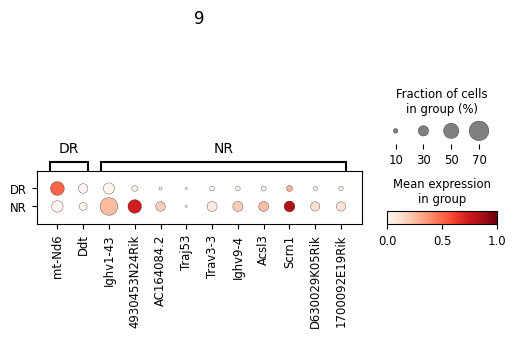

/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version 

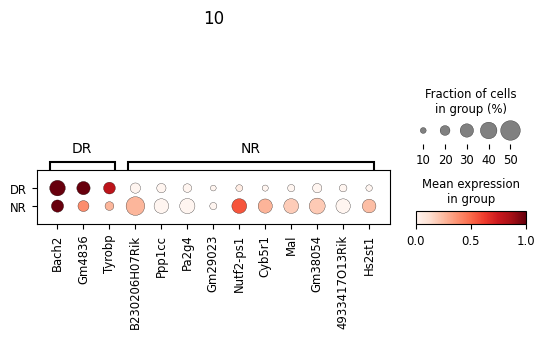

/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version 

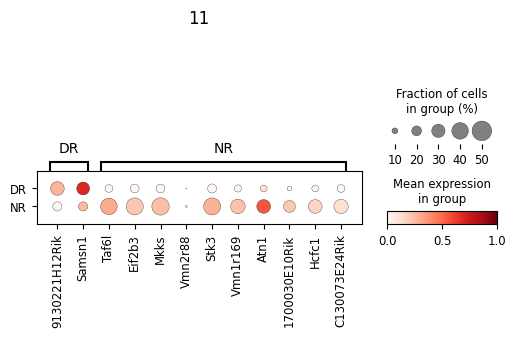

/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', '

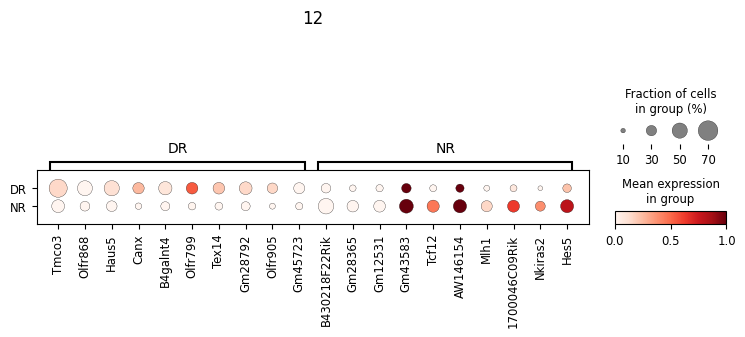

/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', '

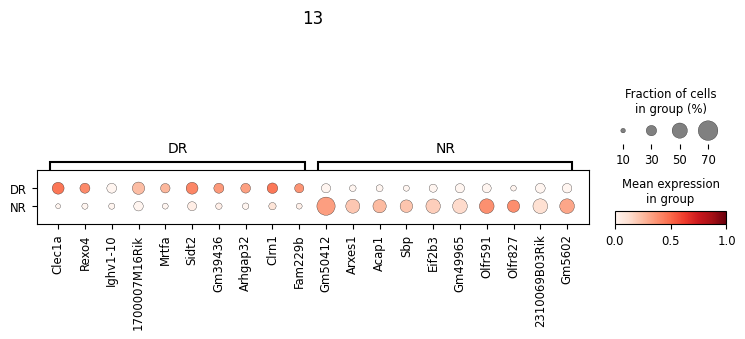

/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', '

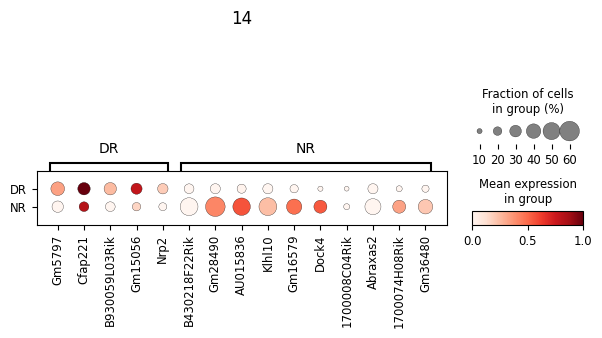

/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', '

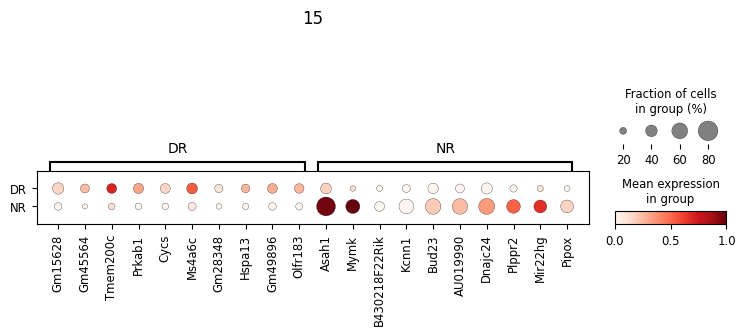

/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', '

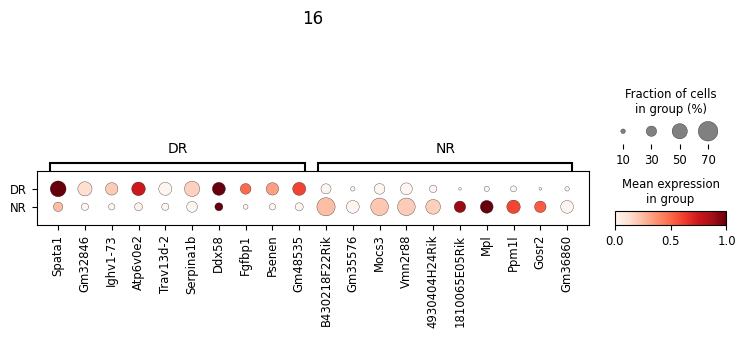

/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', '

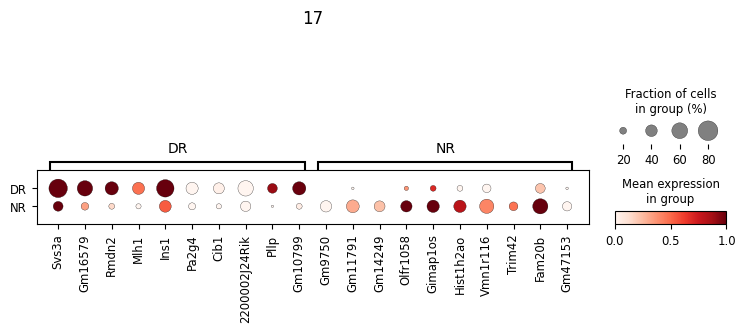

/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_

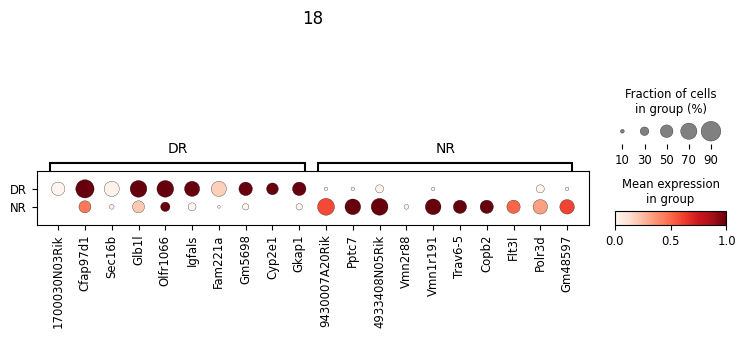

/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_

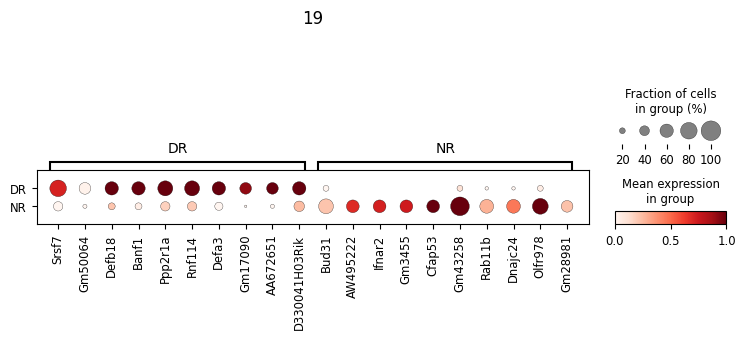

/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_

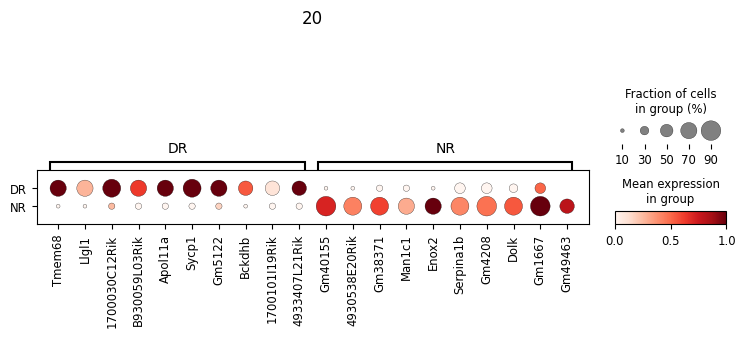

/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_

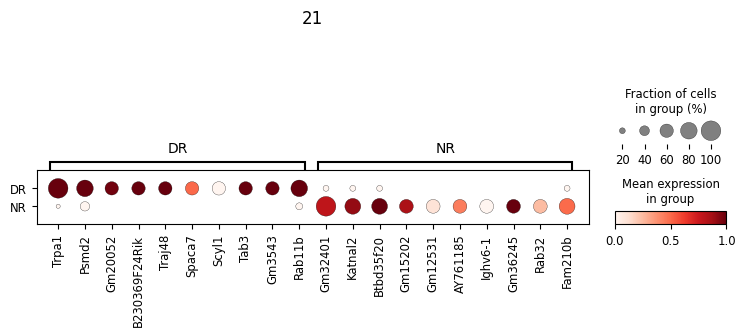

In [33]:
#class_subtypes = sue.create_subtypes(adata,groupby='subclass',key='NRDR_leiden',subgroups=sco.CLASS_ORDER,key_added='subtypes',output_f="")
split_key,type_key,key_added='rearing_condition','NRDR_leiden','rank_genes_groups_filtered'
info,hits = sue.get_stratified_diff_genes(adata,split_key,type_key,key_added,subcats=None,plot=True,output_dir=os.path.join(figure_dir,"genes"),pre='NN')

['Vmn2r88', 'Oog2', 'Gm28365', '4930453N24Rik', 'Gm48281', 'Ighv1-43', 'AC164084.2', 'Traj53', 'Trav3-3', 'Ighv9-4', 'Acsl3', 'Scrn1', 'D630029K05Rik', '1700092E19Rik', 'AL845275.1', 'Slc20a1', 'Gm45181', 'B430218F22Rik', 'Gm28490', 'AU015836', 'Klhl10', 'Gm16579', 'Dock4', '1700008C04Rik', 'Abraxas2', '1700074H08Rik', 'Gm36480', 'Gm15334', 'Gm37362', 'Samd13', 'Cnbp', 'Srrm4os', 'Plppr4', 'Pnmal1', 'Casp14', 'Svs5', 'Myh8', 'Gm38182', 'Man1c1', 'Eps8l2', 'Stag3', 'Ighv1-66', 'Cmtm2a', 'Plvap', 'Cyp3a41a', 'Abcc10', 'Maml2', 'Lrrcc1', 'Gm9946', 'Adam1a', 'Gm34934', 'Ms4a12', 'Gm7929', 'Rsad1', 'Gm28447', 'Gm48526', 'Ppp1r3c', '1700047M11Rik', 'Mgst1', 'Gm45510', 'Abcc9', 'Gm43583', 'Ighv1-21-1', 'Pinx1', 'Hagh', 'Nipal3', 'Elovl2', 'B230359F08Rik', 'Iglv1', 'Myh6', '4930513L16Rik', 'Pla2g12a', 'Ces3a', 'Higd1a', 'Vkorc1l1', 'B230206H07Rik', 'Ppp1cc', 'Pa2g4', 'Gm29023', 'Nutf2-ps1', 'Cyb5r1', 'Mal', 'Gm38054', '4933417O13Rik', 'Hs2st1', '1700023F02Rik', 'Btbd6', 'Lonrf1', 'Gm14435', 'Z

/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', '

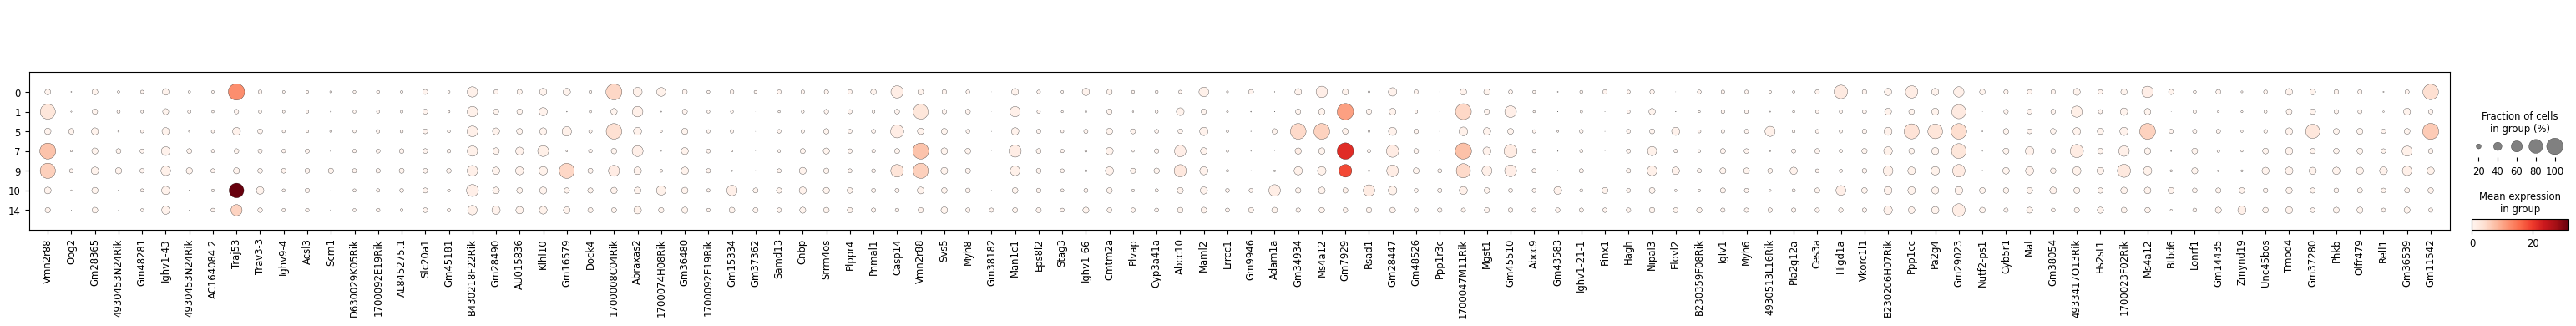

In [35]:
pl.construct_dotplot(adata,marker_genes=info['diff_genes']['NR'],cluster_key='NRDR_leiden',include=['0','1','5','7','9','14','10'])


/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/Users/kushalnimkar/miniforge3/envs/stereo_seq/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', '

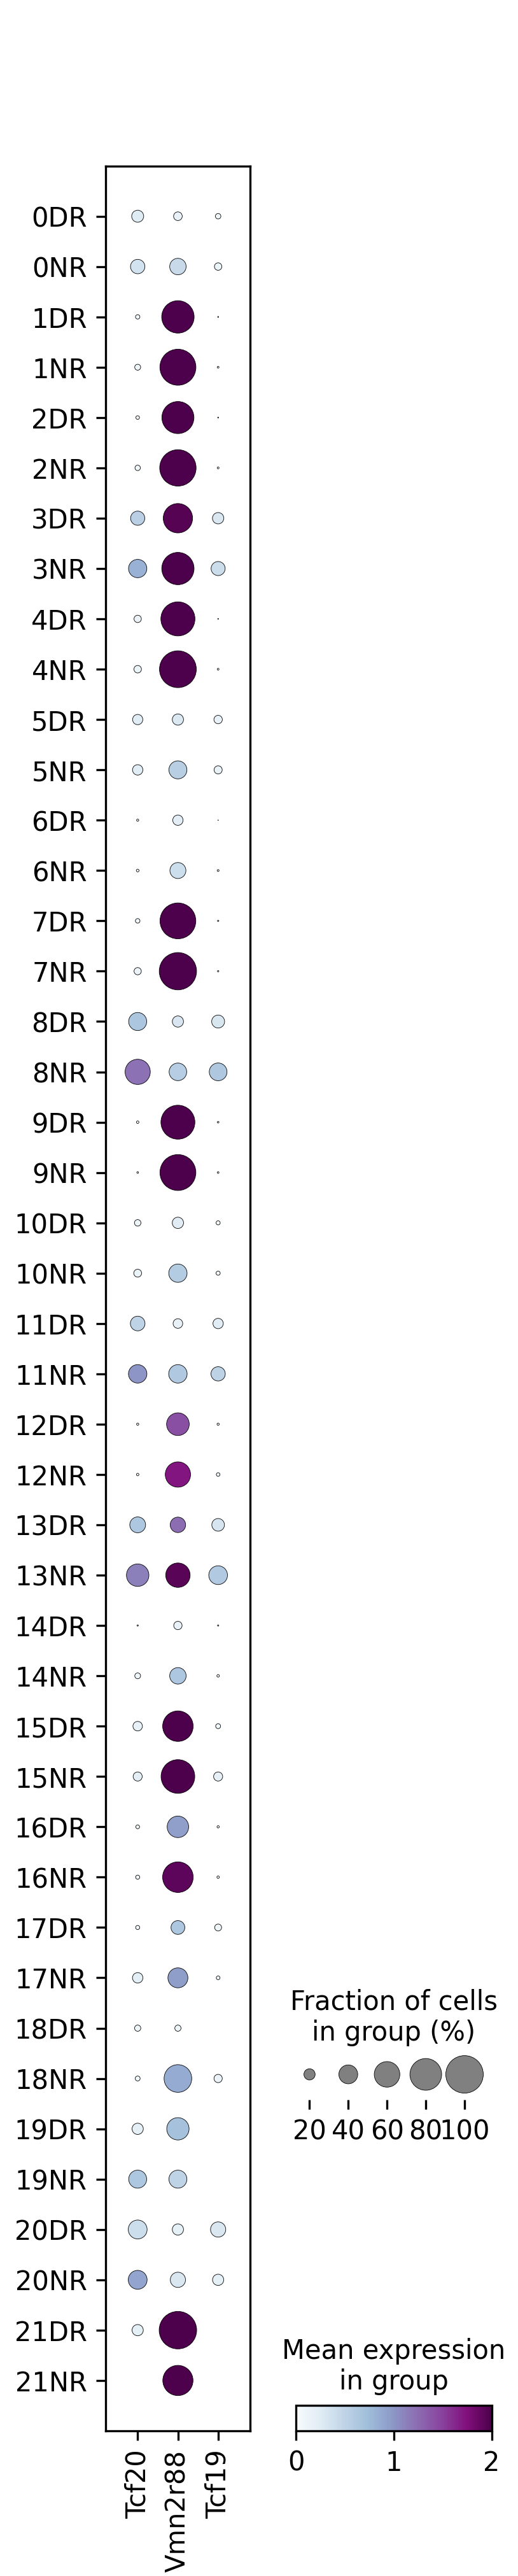

In [36]:
adata.obs['condition_leiden'] =  adata.obs['NRDR_leiden'].astype(str) + adata.obs['rearing_condition'].astype(str)
with plt.rc_context(PLT_CONTEXT):
    sc.pl.dotplot(adata,groupby='condition_leiden',var_names=['Tcf20','Vmn2r88','Tcf19'],vmin=0,vmax=2,swap_axes=False,cmap='BuPu',show=False)
    plt.savefig(os.path.join(figure_dir,"excitatory_possible.png"),bbox_inches='tight')